In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def fix_df(df):
    # to categorical and rename
    df['modeltype'] = df['modeltype'].apply(lambda x: 'Group SPCA' if x=='group' else 'Multimodal SPCA' if x=='mm' else 'Multimodal, multisubject SPCA')
    df['lambda1'] = df['lambda1'].apply(lambda x: '$0$' if x==0.0 else '$10^{'+str(int(np.round(np.log10(x))))+'}$')
    df['lambda2'] = df['lambda2'].apply(lambda x: '$0$' if x==0.0 else '$10^{'+str(int(np.round(np.log10(x))))+'}$')
    return df

def get_dfs(get_best_val = True,output_test = False,QP = False):
    PCAICA = pd.read_csv('../data/PCA_ICA_results.csv')
    PCAICA = PCAICA[PCAICA['modeltype']=='PCA']
    df_all = PCAICA
    for modeltype in ['group', 'mm', 'mmms']:
        for init_method in ['group_PCA','random']:
            for K in range(2,21):
                try:
                    if QP:
                        df = pd.read_csv('../data/SPCA_results/SPCA_QP_results_K='+str(K)+'_'+modeltype+'_'+init_method+'.csv')
                        df['inference'] = 'QP'
                    else:
                        df = pd.read_csv('../data/SPCA_results/SPCA_results_K='+str(K)+'_'+modeltype+'_'+init_method+'.csv')
                        df['inference'] = 'Torch'
                except:
                    continue
                df = fix_df(df)
                if get_best_val:
                    best_row = df.loc[[df['val_loss'].idxmin()]]
                    if output_test:
                        df_test = df[df['lambda1']==best_row['lambda1'].values[0]]
                        df_test = df_test[df_test['lambda2']==best_row['lambda2'].values[0]]
                        df_all = pd.concat([df_all, df_test], ignore_index=True)
                    else:
                        df_all = pd.concat([df_all, best_row], ignore_index=True)
                else:
                    df_all = pd.concat([df_all, df], ignore_index=True)
    return df_all

In [ ]:
# use get_best_val for a table on the chosen best model (e.g., for a table)
df = get_dfs(get_best_val = True)
df = df[df['modeltype']!='PCA']
df = df[df['init_method']=='group_PCA']

newdf = pd.DataFrame(columns=['Group_l1','Group_l2','Multimodal_l1','Multimodal_l2','Multimodal, multisubject_l1','Multimodal, multisubject_l2'])
for i in range(2,21):
    dfi = df[df['K']==i]
    newdf.loc[i] = [dfi[df['modeltype']=='Group SPCA']['lambda1'].values[0],dfi[df['modeltype']=='Group SPCA']['lambda2'].values[0],dfi[df['modeltype']=='Multimodal SPCA']['lambda1'].values[0],dfi[df['modeltype']=='Multimodal SPCA']['lambda2'].values[0],dfi[df['modeltype']=='Multimodal, multisubject SPCA']['lambda1'].values[0],dfi[df['modeltype']=='Multimodal, multisubject SPCA']['lambda2'].values[0]]

newdf.to_latex('../SPCA_best_params.tex')

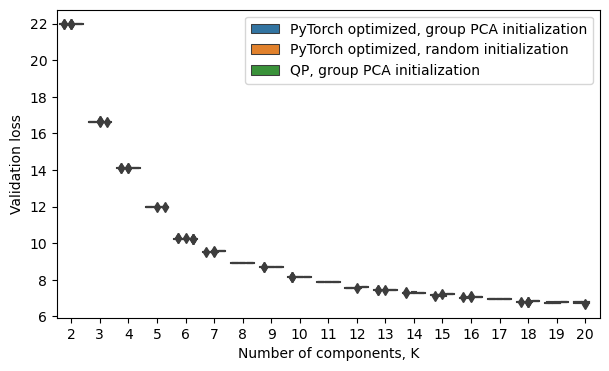

In [13]:
# output_test for a table on the test loss of the chosen best model (e.g., for a table)
df1 = get_dfs(get_best_val = True, output_test = True)
df11 = df1[df1['init_method']=='group_PCA']
df11['Mtype'] = 'PyTorch optimized, group PCA initialization'
df12 = df1[df1['init_method']=='random']
df12['Mtype'] = 'PyTorch optimized, random initialization'
df2 = get_dfs(get_best_val = True, output_test = True, QP = True)
df2['Mtype'] = 'QP, group PCA initialization'
df = pd.concat([df11,df12,df2], ignore_index=True)
df['Test loss'] = df['test_loss']
df['Validation loss'] = df['val_loss']
df['Number of components, K'] = df['K']
plt.figure(figsize=(7,4))
g = sns.boxplot(x='Number of components, K', y='Validation loss',hue='Mtype', data=df[df['modeltype']=='Group SPCA'])
g.legend_.set_title('')
plt.savefig('../reports/loss_models.png',dpi=300,bbox_inches='tight')

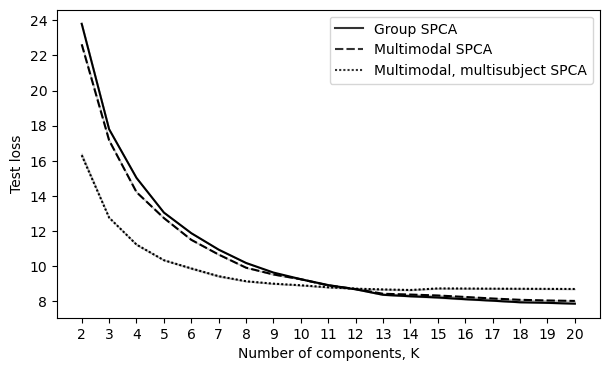

In [15]:
# output_test for a table on the test loss of the chosen best model (e.g., for a table)
df = get_dfs(get_best_val = True, output_test = True)
df = df[df['init_method']!='random']
df = df[df['modeltype']!='PCA']
df['Test loss'] = df['test_loss']
df['Validation loss'] = df['val_loss']
df['Number of components, K'] = df['K']
plt.figure(figsize=(7,4))
g = sns.lineplot(x='Number of components, K', y='Test loss',style='modeltype', data=df,color='black')
g.legend_.set_title('')
plt.xticks(range(2,21));
plt.savefig('../reports/loss_model_order.png',dpi=300,bbox_inches='tight')

<Axes: xlabel='K', ylabel='test_loss'>

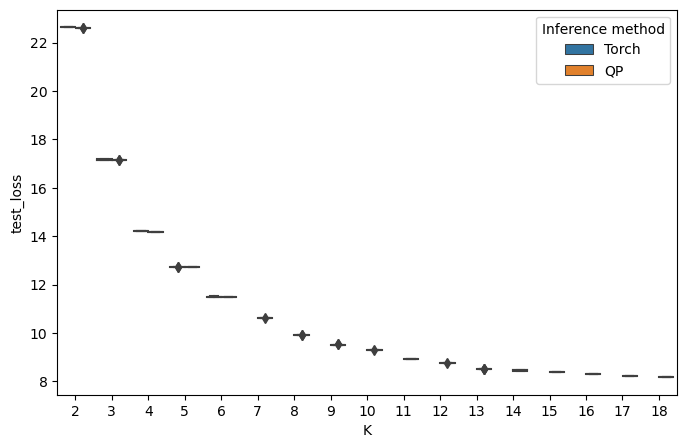

In [ ]:
df1 = get_dfs(get_best_val = True, output_test = True)
df1 = df1[df1['init_method']!='random']
df2 = get_dfs(get_best_val = True, output_test = True,QP=True)
df1['Inference method'] = 'Torch'
df2['Inference method'] = 'QP'
df = pd.concat([df1,df2],ignore_index=True)
plt.figure(figsize=(8,5))
# sns.boxplot(x='K', y='test_loss',hue='Inference method', data=df[df['modeltype']=='Multimodal, multisubject'])
sns.boxplot(x='K', y='test_loss',hue='Inference method', data=df[df['modeltype']=='Multimodal'])